In [4]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [111]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

#varcluster_info=pd.DataFrame(
#{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
#,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
#,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
#})

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

## 1.1 Word Embedding

In [8]:
## Word Embeddings Functions


## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [9]:
## creating a tagged document
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]
tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [10]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-24 10:45:34.346856 Started
2020-01-24 10:51:59.365372 Completed


In [12]:
## Validating the model response for random words 

modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.65 'situation'
    2. 0.65 'system'
    3. 0.63 'constantly'
    4. 0.62 'kind'
    5. 0.61 'way'
    6. 0.60 'habitat'
    7. 0.59 'reservoir'
    8. 0.58 'contexts'
    9. 0.58 'resource'
    10. 0.58 'climatically'
    11. 0.57 'scenario'
    12. 0.57 'continuously'
    13. 0.57 'setting'
    14. 0.57 'potentially'
    15. 0.55 'environments'
    16. 0.55 'object'
    17. 0.55 'community'
    18. 0.55 'circumstance'
    19. 0.55 'obviously'
    20. 0.55 'area'


## 1.2. PCA

In [69]:
## PCA - reducing the dimenstion
ps=10
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 10 Variance coveragence 38.44817578792572


In [76]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

# 2. DBScan

In [77]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer = DBSCAN(eps=2.6, min_samples=5, n_jobs=4)
    
    #### Hyper parameter ####
    # eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples -The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
    
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-01-24 11:54:58.647705 Started
******Natural Sciences******
 0    13380
-1      344
dtype: int64
silhouette score: 0.30240855
2020-01-24 11:55:08.441916 Completed

2020-01-24 11:55:08.442041 Started
******Humanities and Social Sciences******
 0    9688
-1     296
dtype: int64
silhouette score: 0.31571138
2020-01-24 11:55:13.814395 Completed

2020-01-24 11:55:13.814541 Started
******Engineering Sciences******
 0    9000
-1     376
dtype: int64
silhouette score: 0.27325392
2020-01-24 11:55:18.337387 Completed

2020-01-24 11:55:18.339319 Started
******Life Sciences******
 0    17472
-1      477
dtype: int64
silhouette score: 0.31985968
2020-01-24 11:55:34.955012 Completed



In [16]:
merged_data['DBScanCluster'].value_counts()

 0    49537
-1     1496
Name: DBScanCluster, dtype: int64

In [35]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]

merged_data['CategoryConv']=merged_data.Category.apply(CattoID)

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [20]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the DBScanCluster result. outlier data are considering as test data to reevaluate.

X_Training_DS=merged_data[Features][merged_data.DBScanCluster==0]
y_Training_DS=merged_data[OP_Feature][merged_data.DBScanCluster==0]

X_Test_DS=merged_data[Features][merged_data.DBScanCluster!=0]
y_Test_DS=merged_data[OP_Feature][merged_data.DBScanCluster!=0]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

## 3.1 NaiveBayes

Accuracy Score : 34.91118288251918


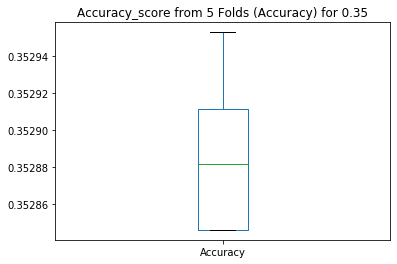

In [21]:
modelNB = MultinomialNB(alpha=1)

#### Hyper parameter ####
# alpha - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

## 3.1  k-nearest neighbors 

In [41]:
for k in [4,8,16,25,30]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

neighbors: 4 Accuracy Score : 0.8576907549454986
neighbors: 8 Accuracy Score : 0.873031893419459
neighbors: 16 Accuracy Score : 0.8793903916027452
neighbors: 25 Accuracy Score : 0.8803996770286637
neighbors: 30 Accuracy Score : 0.8797941057731127


neighbors: 25 Accuracy Score : 0.8803996770286637


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.88')

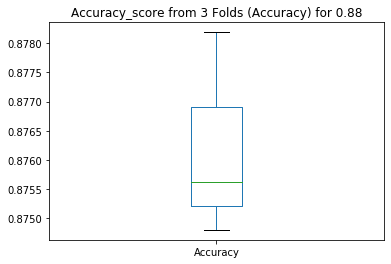

In [42]:
k=25
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)
print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

2020-01-24 10:53:11.357936 Started
2020-01-24 10:53:11.732016 Fit Completed
Accuracy Score : 83.44771901493743
2020-01-24 10:53:12.725544 Completed


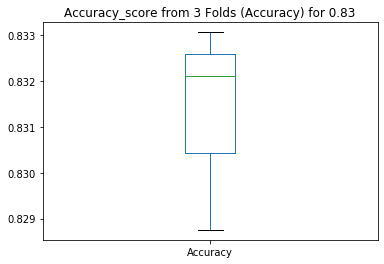

In [23]:
print(str(datetime.datetime.now()),'Started')

modelSVC = svm.LinearSVC(C=0.01)

#### Hyper parameter ####
# C - The strength of the regularization is inversely proportional to C.

modelSVC.fit(X_train, y_train)

print(str(datetime.datetime.now()),'Fit Completed')
nfolds=3
scores=cross_val_score(modelSVC, X_train, y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelSVC.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

print(str(datetime.datetime.now()),'Completed')

## 4. Formatting the output categories based on the predict_proba

In [24]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

## 5.1. Random manual result evaluvation 

In [26]:
PredictedValues.head(16694).tail(5)

,Engineering Sciences,Humanities and Social Sciences,Natural Sciences,Life Sciences,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
16689,0.00,0.0,0.04,0.96,0.96,0.04,0.00,Life Sciences,Natural Sciences,,0.92,0.04
16690,0.00,0.0,0.56,0.44,0.56,0.44,0.00,Natural Sciences,Life Sciences,,0.12,0.44
16691,0.04,0.0,0.24,0.72,0.72,0.24,0.04,Life Sciences,Natural Sciences,Engineering Sciences,0.48,0.20
16692,0.04,0.0,0.88,0.08,0.88,0.08,0.04,Natural Sciences,Life Sciences,Engineering Sciences,0.80,0.04
16693,0.04,0.0,0.96,0.00,0.96,0.04,0.00,Natural Sciences,Engineering Sciences,,0.92,0.04


In [27]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [45]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    5841
-1     511
Name: DBScanCluster, dtype: int64

In [48]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Engineering Sciences              162
Natural Sciences                  159
Life Sciences                     130
Humanities and Social Sciences     60
Name: Category, dtype: int64

In [51]:
cats='Natural Sciences'
lim=200
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster==0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
24219,"In the first funding period, the spatial distr...",Natural Sciences,0.88,0.12,0.00,Engineering Sciences,Natural Sciences,,0.76,0.12
33956,The functional properties of G-protein coupled...,Natural Sciences,0.88,0.12,0.00,Life Sciences,Natural Sciences,,0.76,0.12
47528,"The energy losses in transformers, generators ...",Natural Sciences,0.88,0.12,0.00,Engineering Sciences,Natural Sciences,,0.76,0.12
37108,Celiac disease (CD) is one of the most frequen...,Natural Sciences,0.88,0.12,0.00,Life Sciences,Natural Sciences,,0.76,0.12
15224,West German cities have undergone a profound c...,Natural Sciences,0.88,0.08,0.04,Humanities and Social Sciences,Natural Sciences,Engineering Sciences,0.80,0.04


In [52]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster==0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

['In the first funding period, the spatial distribution of the material parameters was identified as an indicator of structural damage in fiber composites. The relationship of these parameters with the signals measured at the sensors was described by a parameter identification based on an initial boundary value problem for the anisotropic wave equation. Finally, two constrained optimal control problems were formulated, which cast the problem of damage detection into a mathematical form and where the initial Randwertproblem each emerges as a constraint. Numerical simulations using synthetic data already exist for one of these two problems, proving the suitability of the method even with limited data range for damage detection. In the third funding period, these two models will now be further analyzed and refined in close cooperation with the other subprojects. Finally, the resulting processes should be implemented and their performance should be tested and evaluated on real measured dat

In [53]:
#NewMergedDSAligned.to_csv(Path+'WEPCADBScanFindingsKMeans.csv', index=False)

## 5.2. Each category TF/IDF based result evaluvation 

In [238]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [239]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [240]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [242]:
input_data.head()

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,DBScanCluster,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance,CategoryCollc
494,Berücksichtigung der Relaxation bei Hochfreque...,/gepris/projekt/5102204,1998,2002,Radiology and Nuclear Medicine,Eberhard Karls Universität Tübingen,Im bisherigen Verlauf des DFG-Projektes wurden...,In the course of the DFG project so far method...,Consider relaxation of high-frequency pulses f...,course dfg project far method develop investig...,...,-1,0.68,0.16,0.16,Engineering Sciences,Natural Sciences,Life Sciences,0.52,0.00,"Life Sciences,Engineering Sciences,Natural Sci..."
805,Psychophysik der Bewegungskohärenz,/gepris/projekt/5122972,1998,2002,Clinical Neurosciences III - Ophthalmology,Universitätsklinikum Freiburg,"Wir beabsichtigen, unsere Untersuchung der Wah...",We intend to extend our study of the perceptio...,Psychophysics of movement coherence,intend extend study perception coherent motion...,...,-1,0.52,0.48,0.00,Natural Sciences,Humanities and Social Sciences,,0.04,0.48,"Life Sciences,Natural Sciences,Humanities and ..."
1863,Analytische Bestimmung von Spurenbestandteilen...,/gepris/projekt/5176652,1999,2003,"Analytical Chemistry, Method Development (Chem...",Friedrich-Schiller-Universität Jena,Die Charakterisierung und Unterscheidung von W...,The characterization and distinction of wines ...,Analytical determination of trace constituents...,characterization distinction wine origin quali...,...,-1,0.60,0.32,0.08,Humanities and Social Sciences,Life Sciences,Engineering Sciences,0.28,0.24,"Natural Sciences,Humanities and Social Science..."
3158,Modellierung der dynamischen Belagsverteilung ...,/gepris/projekt/5212868,1999,2002,Plant Cultivation and Agricultural Technology,Bundesforschungsinstitut für Kulturpflanzen,Die Zusammenhänge zwischen Gestängebewegungen ...,The relationships between boom movements and p...,Modeling the dynamic coating distribution of f...,relationship boom movement pad distribution fi...,...,-1,0.96,0.04,0.00,Engineering Sciences,Humanities and Social Sciences,,0.92,0.04,"Life Sciences,Engineering Sciences,Humanities ..."
3196,Direktsynthese filteraktiver keramischer Schic...,/gepris/projekt/5213992,1999,2004,Sintered Metallic and Ceramic Materials,Technische Universität Bergakademie Freiberg,"Sonographische Untersuchungen zeigten, dass Pa...",Sonographic examinations showed that patients ...,Direct synthesis of filter-active ceramic laye...,sonographic examination show patient parkinson...,...,-1,0.96,0.04,0.00,Life Sciences,Natural Sciences,,0.92,0.04,"Engineering Sciences,Life Sciences,Natural Sci..."


In [245]:
sizes=len(input_data.CategoryCollc.unique())
#plt.subplots(figsize=(8,150)) 
j=1

for i,bucket in input_data.groupby(['CategoryCollc']):
    
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(bucket))
    
    if(len(bucket)>1):
        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[['Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        #print(varcat.category.value_counts())
        #print(varcat.apply(lambda x: x.Variable +' - NA' if(pd.isnull(x.category)) else x.Variable +'  - '+x.category , axis=1))
        print('Rare words',list(varcat[varcat.category!='General'].Variable))
    
    else:
        print(bucket.Translates.tolist())
    
    print('----------------------------------------------------------')
    
    #print(features_df.sum().sort_values(ascending=False),'\n')
    
    #vectorizer.get_feature_names()
 
    #plt.subplot(1,sizes,j)
    #features_df.sum().sort_values(ascending=False).plot(kind='bar',color='green')
    #plt.title(i.split(',')[0]+' -'+','.join(i.split(',')[1:]))
    #plt.xticks(rotation=60)
    
    #j=j+1
    #plt.tight_layout()
    

Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 6
Rare words ['metal', 'landscape', 'design', 'jewish', 'medium', 'research', 'study', 'political', 'conflict', 'architecture', 'building', 'architectural', 'public', 'mass', 'east', 'process', 'history']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 14
Rare words ['building', 'system', 'architecture', 'design', 'architectural', 'new', 'research', 'concept', 'learning', 'urban', 'model', 'development', 'study', 'develop', 'different', 'peer']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences', 'Life Sciences'] : Number of Documents - 7
Rare words ['method', 'perception', 'privacy', 'research', 'vr', 'ess', 'site', 'user', 'development', 'energy', 'model', 'approach', 'exist', 'location', 'regional', '

Rare words ['culture', 'antibiotic', 'sn', 'cultivation', 'cyanobacteria', 'new', 'bone', 'substance', 'molecular', 'echogenicity', 'biomaterial', 'programmable', 'experimental', 'study', 'approach', 'system', 'development']
----------------------------------------------------------
Engineering Sciences - ['Life Sciences', 'Natural Sciences', 'Engineering Sciences'] : Number of Documents - 8
Rare words ['tissue', 'analysis', 'control', 'measurement', 'temperature', 'corona', 'enzyme', 'sensor', 'breath', 'system', 'cell', 'la', 'use', 'protein', 'co', 'formation', 'different', 'culture', 'cellular']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences'] : Number of Documents - 2
Rare words ['radiation', 'wave', 'experiment', 'current', 'equation', 'filter', 'flow', 'allow', 'temperature', 'role', 'basic', 'fraction', 'qbo', 'simulation', 'large', 'numerical', 'high', 'interaction']
---------------------------------------------------------

Rare words ['reference', 'model', 'simulation', 'problem', 'approach', 'agent', 'world', 'real', 'optimization', 'develop', 'domain', 'multi', 'logistic', 'modeling', 'integration', 'complexity', 'development', 'concept', 'methodological']
----------------------------------------------------------
Humanities and Social Sciences - ['Engineering Sciences', 'Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 1
['With recent technological developments, digital images are increasingly being integrated into portable, sensor-controlled and augmented visualisation systems that operate as a function of their environment. While virtual or augmented reality applications have become established in the consumer field, they also promise to yield wide-ranging applications in professional contexts, for instance in industrial production. In fields such as medical practice however, the far-reaching implications of this technological arsenal of devices are becoming clear. Therapeut

Rare words ['body', 'stress', 'study', 'image', 'tactile', 'level', 'individual', 'effect', 'response', 'pain', 'cognitive', 'environmental', 'child', 'disturbance', 'genetic', 'exposure', 'research', 'ses', 'cortisol', 'disorder']
----------------------------------------------------------
Humanities and Social Sciences - ['Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 2
Rare words ['alpha', 'budget', 'suppression', 'price', 'study', 'increase', 'perceptual', 'amplitude', 'reward', 'human', 'effort', 'effect', 'rat', 'economic', 'animal', 'neural', 'task', 'cost', 'experiment']
----------------------------------------------------------
Humanities and Social Sciences - ['Life Sciences', 'Humanities and Social Sciences', 'Natural Sciences'] : Number of Documents - 4
Rare words ['refugee', 'language', 'regional', 'inequality', 'system', 'study', 'reward', 'variation', 'homeostatic', 'control', 'food', 'country', 'linguistic', 'inflow', '

Rare words ['human', 'gulf', 'policy', 'study', 'south', 'climate', 'region', 'sample', 'variation', 'africa', 'tax', 'debt', 'argentinean', 'late', 'competition', 'national', 'population', 'model']
----------------------------------------------------------
Humanities and Social Sciences - ['Natural Sciences', 'Life Sciences'] : Number of Documents - 1
['Within a cross section, the morphology of compact bone can display dramatic variation in microarchitecture and therefore strength properties. The endosteal lamellar pocket (ELP), an easily-defined, dense, lamellar region of the long bone is perhaps the most obvious and informative of these regions (Wanner et al. 2007; Maggiano et al. 2008b; Maggiano et al. 2008a). Our previous pilot study identified ELPs in the majority of femora and humeri found at the Maya site of Xcambó. We suggest the formation of the ELP could coincide with periods of growth before about twenty years of age and, for unknown reasons, persists for decades, documenti

Rare words ['model', 'oxygenator', 'genome', 'code', 'research', 'augustus', 'aaa', 'risk', 'rupture', 'patient', 'wall', 'analysis', 'annotation', 'user', 'parameter', 'currently', 'prediction']
----------------------------------------------------------
Life Sciences - ['Engineering Sciences', 'Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 7
Rare words ['model', 'method', 'system', 'alignment', 'research', 'specie', 'develop', 'shim', 'field', 'imputation', 'development', 'approach', 'phasing', 'large', 'reference', 'propose']
----------------------------------------------------------
Life Sciences - ['Engineering Sciences', 'Life Sciences', 'Natural Sciences'] : Number of Documents - 8
Rare words ['method', 'signal', 'model', 'muscle', 'fracture', 'fruit', 'mc', 'motion', 'cell', '3d', 'bone', 'cement', 'property', 'fibre', 'combination', 'effect', 'phosphate', 'development']
----------------------------------------------------------
Life Sciences - ['Engi

Rare words ['model', 'soil', 'research', 'water', 'different', 'measurement', 'study', 'change', 'vegetation', 'root', 'spatial', 'potential', 'high', 'scale', 'state', 'system', 'quantum', 'rydberg']
----------------------------------------------------------
Life Sciences - ['Natural Sciences', 'Life Sciences', 'Engineering Sciences'] : Number of Documents - 8
Rare words ['protein', 'enzyme', 'new', 'function', 'structure', 'carbon', 'myosin', 'flow', 'model', 'study', 'lateral', 'water', 'trait', 'bone', 'mustelid', 'soil', 'locomotor', 'habit', 'muscle']
----------------------------------------------------------
Life Sciences - ['Natural Sciences', 'Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 4
Rare words ['emission', 'earth', 'balance', 'climate', 'dynamical', 'urban', 'tree', 'measure', 'early', 'different', 'germany', 'äôs', 'growth', 'spp', 'sample', 'process', 'study']
----------------------------------------------------------
Natural Sciences - ['

Rare words ['network', 'place', 'value', 'aa', 'object', 'spatial', 'model', 'quality', 'reference', 'map', 'classification', 'change', 'method', 'integration', 'different', 'social']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences', 'Life Sciences'] : Number of Documents - 2
Rare words ['prosthesis', 'method', 'ear', 'model', 'material', 'middle', 'develop', 'vocal', 'optimization', 'hand', 'fold', 'measurement', 'help', 'experiment', 'formation', 'special', 'property']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences', 'Life Sciences', 'Natural Sciences'] : Number of Documents - 4
Rare words ['ha', 'alloy', 'corrosion', 'step', 'vgi', 'contact', 'cartilage', 'osm', 'layer', 'joint', 'articular', 'research', 'method', 'use', 'image', 'study', 'develop']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences', 'Natural Sciences'] : Numbe

Rare words ['sand', 'social', 'resource', 'process', 'capital', 'study', 'transocap', 'community', 'area', 'marketization', 'network', 'local', 'vs', 'research', 'different', 'ii', 'tie']
----------------------------------------------------------
Natural Sciences - ['Life Sciences'] : Number of Documents - 6
Rare words ['virus', 'ltp', 'xa', 'disease', 'water', 'protein', 'crispr', 'brain', 'sod1', 'model', 'formation', 'molecular', 'cancer', 'ad', 'neuroblastoma', 'study', 'sg', 'method', 'cell', 'form']
----------------------------------------------------------
Natural Sciences - ['Life Sciences', 'Engineering Sciences'] : Number of Documents - 2
Rare words ['np', 'virus', 'sludge', 'elimination', 'biological', 'process', 'water', 'activate', 'system', 'effect', 'cellular', 'model', 'response', 'property', 'nps', 'induce', 'characterization', 'surface', 'exposure', 'study']
----------------------------------------------------------
Natural Sciences - ['Life Sciences', 'Engineering Sc

# Visualization

In [433]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=0)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

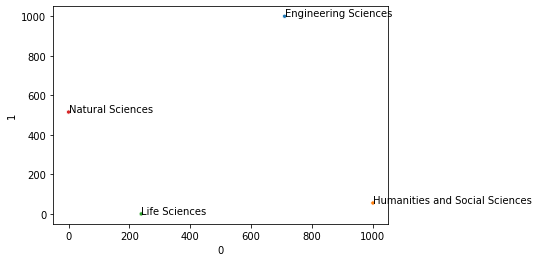

In [434]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

#coords = TSNE(n_components=2,perplexity=.1, random_state=23, metric='precomputed').fit_transform(sym_dist)
coords = PCA(n_components=2, svd_solver = 'full').fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [435]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.412015,0.493970,0.458865
Humanities and Social Sciences,0.412015,0.000000,0.426739,0.670807
Life Sciences,0.493970,0.426739,0.000000,0.260433
Natural Sciences,0.458865,0.670807,0.260433,0.000000


In [436]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,238.749707,0.000000,14.387207,463.112207,-134.617500,134.617500
1,Natural Sciences,171.5500,0.000000,515.398622,-171.550000,171.550000,412.468622,618.328622
2,Humanities and Social Sciences,124.8000,1000.000000,55.262547,875.200000,1124.800000,-19.617453,130.142547
3,Engineering Sciences,117.2000,709.907507,1000.000000,592.707507,827.107507,929.680000,1070.320000


In [440]:
pca.shape

(51033, 10)

In [469]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-01-24 19:04:37.535850 Started for Engineering Sciences
2020-01-24 19:04:58.009646 Completed for Engineering Sciences
2020-01-24 19:04:58.009863 Started for Humanities and Social Sciences
2020-01-24 19:05:23.071089 Completed for Humanities and Social Sciences
2020-01-24 19:05:23.071649 Started for Life Sciences
2020-01-24 19:06:12.744538 Completed for Life Sciences
2020-01-24 19:06:12.744709 Started for Natural Sciences
2020-01-24 19:06:48.492042 Completed for Natural Sciences


In [470]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


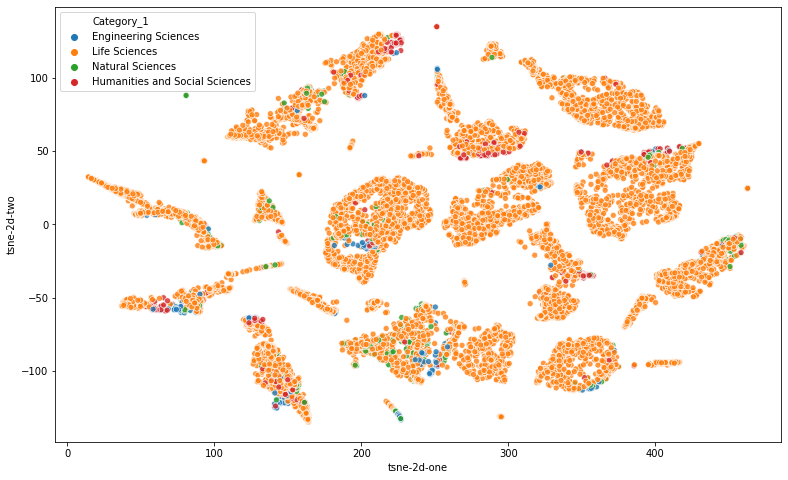

In [471]:
cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

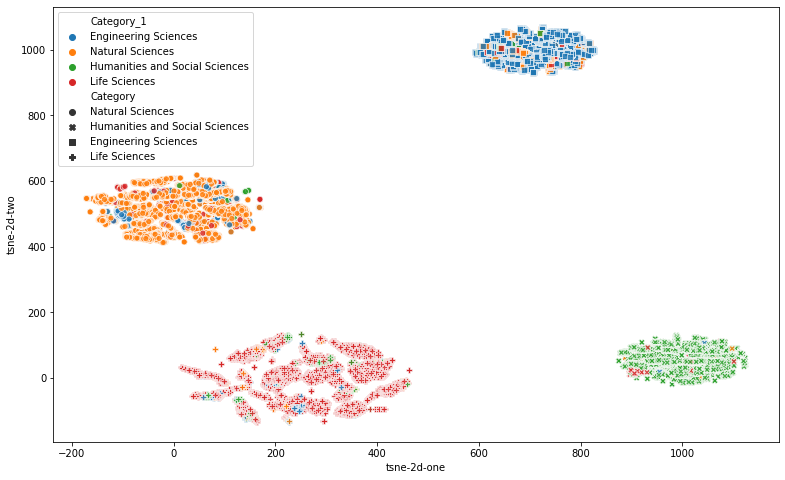

In [472]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [473]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.DBScanCluster==0)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','DBScanCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (NewMergedDSAligned2['DBScanCluster']!=0),'interdiscipilinary']=True

In [474]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [475]:
Report_extrat.to_csv(Path+'Report_WEPCADBScanFindingsKMeansV2.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCADBScanFindingsKMeansV2.csv', index=False)